# This is a super old notebook, there are comparisons with kaon decays and other stuff

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from fourvec import *

In [2]:
m4_model = {
    "L1": 0.42,
    "L2": 0.1,
    "H1": 0.12,
}

mzprime_model = {
    "L1": 0.03,
    "L2": 0.03,
    "H1": 1.25,
}

ctau_model = {
    "L1": [0.1, 1, 10, 100, 1000],
    "L2": [0.1, 1, 10, 100, 1000],
    "H1": [0.1, 2, 10, 100, 1000],
}

!mkdir ../../fig/comparison_bp_l1/
!mkdir ../../fig/comparison_bp_l2/
!mkdir ../../fig/comparison_bp_h1/

save_folder_model = {
    "L1": "../../fig/comparison_bp_l1/",
    "L2": "../../fig/comparison_bp_l2/",
    "H1": "../../fig/comparison_bp_h1/",
}

mkdir: cannot create directory ‘../../fig/comparison_bp_l1/’: File exists
mkdir: cannot create directory ‘../../fig/comparison_bp_l2/’: File exists
mkdir: cannot create directory ‘../../fig/comparison_bp_h1/’: File exists


In [3]:
model = "L1"
m4 = m4_model[model]
mzprime = mzprime_model[model]
ctaus = ctau_model[model]
save_folder = save_folder_model[model]

In [4]:
def decay_particle(df, ctau):
    p3dark = np.sqrt(dot3_df(df['pdark'], df['pdark']))
    mdark = inv_mass(df['pdark'])
    betagamma = p3dark/mdark
    gamma = df['pdark', 't']/mdark
    beta = betagamma/gamma
    
    d_decay = np.random.exponential(scale=ctau*betagamma) # centimeters

    df[f'decay_point_{ctau}', 't'] = df['int_point', 't'] + d_decay/(2.998e+10 * beta)
    df[f'decay_point_{ctau}', 'x'] = df['int_point', 'x'] + d_decay*df['pdark', 'x']/p3dark
    df[f'decay_point_{ctau}', 'y'] = df['int_point', 'y'] + d_decay*df['pdark', 'y']/p3dark
    df[f'decay_point_{ctau}', 'z'] = df['int_point', 'z'] + d_decay*df['pdark', 'z']/p3dark

In [5]:
df_upscattering = pd.read_pickle(f'../data/nd280_nu/3plus1/m4_{m4}_mzprime_{mzprime}/MC_m4_{m4}_mzprime_{mzprime}.pckl')
df_kaon_decay = pd.read_pickle(f'../data/nd280_nu/kaon_decay/MC_std_HNL_NCdecay_m4_0.15.pckl')

dfs = {'upscattering': df_upscattering,
       'kaon_decay': df_kaon_decay}

In [6]:
# compute useful variables
for df in dfs.values():
    for comp in ['t','x','y','z']:
        df['pee', comp] = df['plm', comp] + df['plp', comp]
        df['pdark', comp] = df['plm', comp] + df['plp', comp] + df['pnu', comp]
    df['recoil_mass', ''] = inv_mass(df['pHad']).round(6)
    df['ee_mass', ''] = inv_mass(df['pee'])
    df['ee_costheta', ''] = costheta(df['plm'], df['plp'])
    df['nu_dark_beam_costheta', ''] = df['pdark', 'z']/np.sqrt(dot3_df(df['pdark'], df['pdark']))
    df['ee_beam_costheta', ''] = df['pee', 'z']/np.sqrt(dot3_df(df['pee'], df['pee']))
    df['ee_momentum', ''] = np.sqrt(dot3_df(df['pee'], df['pee']))
    df['experimental_t', ''] = (df['plm','t'] - df['plm','z'] + df['plp','t'] - df['plp','z'])**2 +\
                                df['plm','x']**2 + df['plm','y']**2 + df['plp','x']**2 + df['plp','y']**2

In [45]:
cuts_dict = {
    'cut1' : r'cos $\theta_{ee, beam}$ > 0.99',
    'cut2' : r'$t_{exp}$ < 0.03',
    'cut3' : r'cos $\theta_{ee}$ > 0',
    'cut4' : r'$p_{ee}$ > 0.15',

}
for df in dfs.values():
    df['cut1', ''] = (df['ee_beam_costheta', ''] > 0.99)
    df['cut2', ''] = (df['experimental_t', ''] < 0.03)
    df['cut3', ''] = (df['ee_costheta', ''] > 0)
    df['cut4', ''] = (df['ee_momentum', ''] > 0.150)
    df['selected', ''] = df['cut1', ''] &\
                         df['cut2', ''] &\
                         df['cut3', ''] &\
                         df['cut4', '']

In [8]:
total_pot = 2e21

tpc_length = 100 #cm
fgd_length = 36.5 #cm
p0d_length = 240 #cm

p0d_dimensions = [210.3, 223.9, 240]
detector_splitting = {0: [0, 30.5],
                      1: [30.5, 209.6],
                      2: [209.6, 240.0]}

mol2natoms = 6.02214e23 # Avogadro's number
ton2grams = 1e6
geometry_material = {
    'hydrogen': [0, 1, 2],
    'oxygen': [1],
    'carbon': [0, 1, 2],
    'copper': [1],
    'zinc': [1],
    'lead': [0, 2],
}

material_dict = {
    0.9385: 'hydrogen',
    11.262: 'carbon',
    15.016: 'oxygen',
    59.637921: 'copper',
    61.35913: 'zinc',
    194.4572: 'lead'
}

gev_mass = dict(zip(material_dict.values(), material_dict.keys()))

molar_mass = {
    'hydrogen': 1.00784,
    'carbon': 12.0107,
    'oxygen': 15.999,
    'copper': 63.546,
    'zinc': 65.38,
    'lead': 207.2
}

mass_material = {
    'hydrogen': 3.3*2*molar_mass['hydrogen']/(2*molar_mass['hydrogen'] + molar_mass['oxygen']),
    'oxygen': 3.3*molar_mass['oxygen']/(2*molar_mass['hydrogen'] + molar_mass['oxygen']),
    'carbon': 8.221,
    'copper': 1.315*0.66, # percentage of copper in typical brass
    'zinc': 1.315*0.34, # percentage of zinc in typical brass
    'lead': 3.634,
}

df = df_upscattering
ntarget_material = {}
for material, mass in mass_material.items():
    ntarget_material[material] = mass*ton2grams/molar_mass[material]*mol2natoms

    material_mask = (df['recoil_mass'] == gev_mass[material])
    df.loc[material_mask, ('actual_weight', '')] = df['weight', ''][material_mask] * ntarget_material[material] * total_pot

df = df_kaon_decay
df['actual_weight', ''] = df['weight', '']

In [15]:
for name, df in  dfs.items():
    eff = df['actual_weight', ''][df['selected', '']].sum()/df['actual_weight', ''].sum()
    print(f"{name}, efficency = {100*eff:.1f}%")

upscattering, efficency = 47.3%
kaon_decay, efficency = 93.4%


([<matplotlib.axis.XTick at 0x7f1a6a1b8af0>,
 [Text(0, 0, 'cos $\\theta_{ee, beam}$ > 0.99'),
  Text(0, 0, '$t_{exp}$ < 0.03'),
  Text(0, 0, 'cos $\\theta_{ee}$ > 0'),
  Text(0, 0, '$p_{ee}$ > 0.15')])

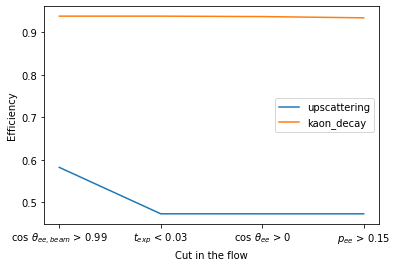

In [46]:
cut_flows = range(1, 5)
for name, df in dfs.items():
    total_selection = np.ones(len(df), dtype=bool)
    aux_efficiency = []
    for cut in cut_flows:
        total_selection = total_selection & df[f'cut{cut}', '']
        this_eff = df['actual_weight', ''][total_selection].sum()/df['actual_weight', ''].sum()
        aux_efficiency.append(this_eff)
    plt.plot(cut_flows, aux_efficiency, label=name)
plt.legend()
plt.ylabel('Efficiency')
plt.xlabel('Cut in the flow')
locs, labels = plt.xticks()
plt.xticks(cut_flows, cuts_dict.values())

Text(0.5, 1.0, 'Kaon decay')

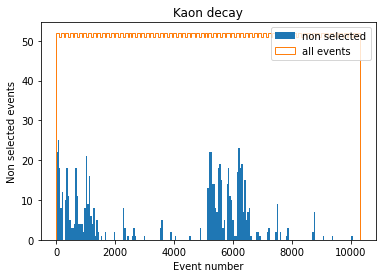

In [9]:
df = dfs['kaon_decay']
plt.hist(df['selected', ''].index[~df['selected', '']].values, bins=200, label='non selected');
plt.hist(df['selected', ''].index.values, bins=200, histtype='step', label='all events');
plt.xlabel('Event number')
plt.ylabel('Non selected events')
plt.legend()
plt.title('Kaon decay')

Text(0.5, 1.0, 'Dark nus upscattering')

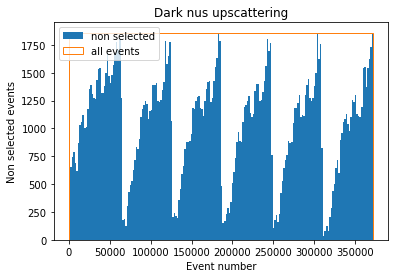

In [14]:
df = dfs['upscattering']
plt.hist(df['selected', ''].index[~df['selected', '']].values, bins=200, label='non selected');
plt.hist(df['selected', ''].index.values, bins=200, histtype='step', label='all events');
plt.xlabel('Event number')
plt.ylabel('Non selected events')
plt.legend()
plt.title('Dark nus upscattering')

Text(0.5, 1.0, 'Dark nus upscattering')

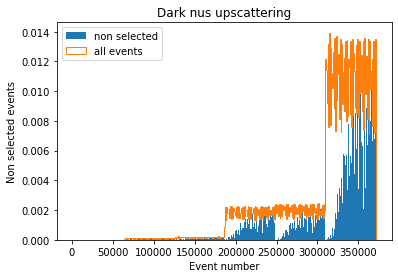

In [22]:
df = dfs['upscattering']
plt.hist(df['selected', ''].index[~df['selected', '']].values, 
         weights=df['weight', ''][~df['selected', '']].values/df['weight', ''].sum(), 
         bins=400, 
         label='non selected');
plt.hist(df['selected', ''].index.values, 
         weights=df['weight', ''].values/df['weight', ''].sum(), 
         bins=400, 
         histtype='step', 
         label='all events');
plt.xlabel('Event number')
plt.ylabel('Non selected events')
plt.legend()
plt.title('Dark nus upscattering')

In [25]:
df['weight', ''][:50].values

array([9.72756621e-55, 8.05701870e-55, 9.29425793e-55, 4.39224495e-55,
       7.91254891e-55, 5.92593681e-55, 7.14813033e-55, 7.04536523e-55,
       9.65189002e-55, 7.91259120e-55, 8.94619065e-55, 6.07449183e-55,
       9.77078991e-55, 7.09198422e-55, 7.92239755e-55, 8.99053596e-55,
       4.83337675e-55, 4.40327270e-55, 6.19927807e-55, 8.54430800e-55,
       8.82414033e-55, 7.55075386e-55, 7.92083068e-55, 9.06825975e-55,
       8.73766803e-55, 5.96523207e-55, 6.25885791e-55, 1.06109477e-54,
       1.26225640e-54, 6.79822213e-55, 9.31652834e-55, 1.18481001e-54,
       1.07969793e-54, 1.19697765e-54, 6.01664423e-55, 1.05201701e-54,
       1.54638472e-54, 1.84633935e-54, 1.45363231e-54, 1.59977814e-54,
       8.12928331e-55, 5.70621609e-55, 5.64566836e-55, 8.17314140e-55,
       1.02744575e-54, 1.02406936e-54, 4.69665006e-55, 5.72772656e-55,
       5.19880275e-55, 9.05587351e-55])

In [26]:
df['weight', ''][-50:].values

array([1.01079367e-051, 1.01176361e-051, 1.24156797e-051, 1.54745361e-051,
       1.51571282e-051, 9.56079797e-052, 9.60931034e-052, 1.27188150e-051,
       1.02258067e-051, 1.60525658e-051, 1.14368583e-051, 1.14848903e-051,
       9.08416135e-052, 9.56683682e-052, 9.69602749e-052, 1.24659050e-051,
       1.07521054e-051, 1.02684683e-051, 1.14149652e-051, 9.64245758e-052,
       1.10629737e-051, 1.78586468e-115, 9.46629440e-052, 1.16192069e-051,
       9.42034130e-052, 1.62369197e-051, 1.06100171e-051, 1.01771328e-051,
       1.77673483e-056, 1.49691847e-051, 8.91967273e-052, 9.39063966e-052,
       9.64423736e-052, 9.08838937e-052, 1.07745322e-051, 1.09238333e-051,
       1.09525552e-051, 9.56447257e-052, 1.13642457e-051, 1.11937149e-051,
       1.19091731e-051, 9.67226053e-052, 9.85917157e-052, 1.02586436e-051,
       1.25199069e-051, 9.02033841e-052, 1.47975349e-051, 9.90830022e-052,
       1.74512222e-051, 1.04089962e-051])

In [15]:
for name, df in  dfs.items():
    eff = df['actual_weight', ''][df['selected', '']].sum()/df['actual_weight', ''].sum()
    print(f"{name}, efficency = {100*eff:.1f}%")

upscattering, efficency = 47.3%


KeyError: ('actual_weight', '')

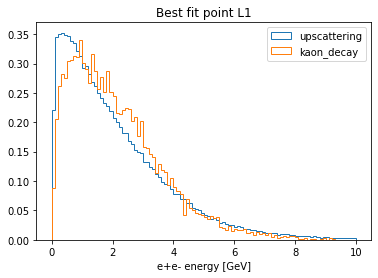

In [33]:
for name, df in dfs.items():
    plt.hist(df['pee', 't'], 
             bins=100, 
             range=[0, 
             10],
             weights=df['actual_weight', ''], 
             density=True,
             histtype='step',
             label=name)
plt.legend()
plt.xlabel('e+e- energy [GeV]')
plt.title(f"Best fit point {model}")
plt.savefig(save_folder+"truth_e+e-_energy.png", dpi=250)

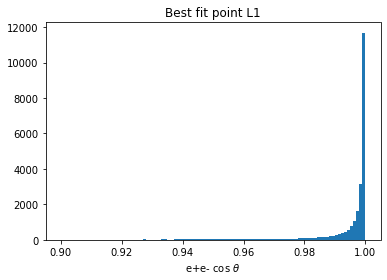

In [23]:
plt.hist(df['ee_costheta', ''], bins=100, range=[0.9, 1], weights=df['actual_weight', ''])
plt.xlabel(r'e+e- cos $\theta$')
plt.title(f"Best fit point {model}")
plt.savefig(save_folder+"truth_costheta.png", dpi=250)

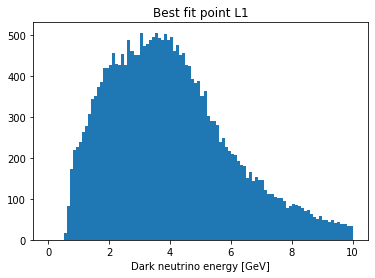

In [24]:
plt.hist(df['pdark', 't'], bins=100, range=[0., 10], weights=df['actual_weight', ''])
plt.xlabel(r'Dark neutrino energy [GeV]')
plt.title(f"Best fit point {model}")
plt.savefig(save_folder+"truth_dark_nu_energy.png", dpi=250)

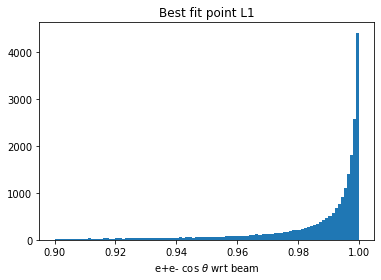

In [28]:
plt.hist(df['ee_beam_costheta', ''], bins=100, range=[0.9, 1], weights=df['actual_weight', ''])
plt.xlabel(r'e+e- cos $\theta$ wrt beam')
plt.title(f"Best fit point {model}")
plt.savefig(save_folder+"truth_ee_beam_costheta.png", dpi=250)

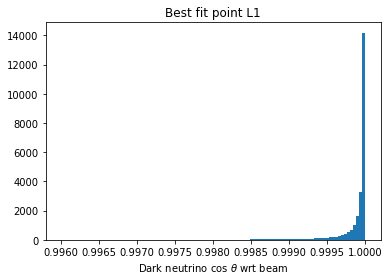

In [31]:
plt.hist(df['nu_dark_beam_costheta', ''], bins=100, range=[0.996, 1], weights=df['actual_weight', ''])
plt.xlabel(r'Dark neutrino cos $\theta$ wrt beam')
plt.title(f"Best fit point {model}")
plt.savefig(save_folder+"truth_dark_nu_beam_costheta.png", dpi=250)

In [69]:
rg = np.random.default_rng()

df['int_point', 't'] = 0
df['int_point', 'x'] = rg.uniform(0, p0d_dimensions[0], len(df))
df['int_point', 'y'] = rg.uniform(0, p0d_dimensions[1], len(df))

for material_mass, material in material_dict.items():
    material_mask = (df['recoil_mass', ''] == material_mass)
    region = rg.choice(geometry_material[material], len(df))

    for splitting, boundaries in detector_splitting.items():
        region_mask = (region == splitting)
        total_mask = material_mask & region_mask
        df.loc[total_mask, ('int_point', 'z')] = rg.uniform(*boundaries, total_mask.sum())

In [79]:
for ctau in ctaus:
    print(ctau)
    decay_particle(df, ctau)
    df.loc[:, (f'decay_in_tpc_{ctau}', '')] = (((p0d_length < df[f'decay_point_{ctau}','z']) & (df[f'decay_point_{ctau}','z'] < (p0d_length + tpc_length)) |
    (p0d_length + tpc_length + fgd_length < df[f'decay_point_{ctau}','z']) & (df[f'decay_point_{ctau}','z'] < (p0d_length + tpc_length + fgd_length + tpc_length)) |
    (p0d_length + 2*(tpc_length + fgd_length) < df[f'decay_point_{ctau}','z']) & (df[f'decay_point_{ctau}','z'] < (p0d_length + 2*(tpc_length + fgd_length) + tpc_length)))) &\
    (detector_splitting[0][0] < df[f'decay_point_{ctau}','x']) & (df[f'decay_point_{ctau}','x'] < detector_splitting[0][1]) &\
    (detector_splitting[1][0] < df[f'decay_point_{ctau}','y']) & (df[f'decay_point_{ctau}','y'] < detector_splitting[1][1])

0.1
2
10
100
1000


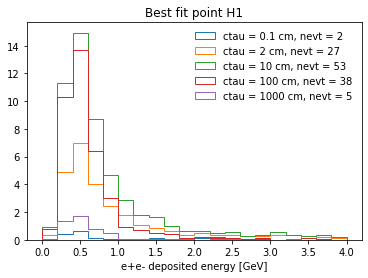

In [80]:
for ctau in ctaus:
    total_selection = selection & df[f'decay_in_tpc_{ctau}']
    out = plt.hist(df['pee', 't'][total_selection], 
                   bins=20, 
                   range=(0, 4),
                   weights=df.loc[total_selection, ('actual_weight', '')], 
                   label=f"ctau = {ctau} cm, nevt = {df.loc[total_selection, ('actual_weight', '')].sum():.0f}", 
                   histtype='step')

plt.legend(frameon=False)
plt.xlabel('e+e- deposited energy [GeV]')
plt.title(f"Best fit point {model}")
plt.savefig(save_folder+"ee_energy.png", dpi=250)

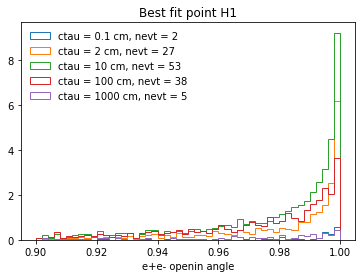

In [81]:
for ctau in ctaus:
    total_selection = selection & df[f'decay_in_tpc_{ctau}']
    out = plt.hist(df['ee_costheta', ''][total_selection], 
                   bins=50, 
                   range=(0.9, 1), 
                   weights=df.loc[total_selection, ('actual_weight', '')], 
                   label=f"ctau = {ctau} cm, nevt = {df.loc[total_selection, ('actual_weight', '')].sum():.0f}", 
                   histtype='step')

plt.legend(frameon=False, loc='upper left')
plt.xlabel('e+e- openin angle')
plt.title(f"Best fit point {model}")
plt.savefig(save_folder+"ee_costheta.png", dpi=250)

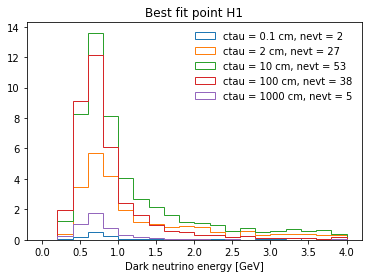

In [82]:
for ctau in ctaus:
    total_selection = selection & df[f'decay_in_tpc_{ctau}']
    out = plt.hist((df['plp', 't']+df['plm', 't']+df['pnu', 't'])[total_selection], 
                   bins=20, 
                   range=(0, 4), 
                   weights=df.loc[total_selection, ('actual_weight', '')], 
                   label=f"ctau = {ctau} cm, nevt = {df.loc[total_selection, ('actual_weight', '')].sum():.0f}", 
                   histtype='step')

plt.legend(frameon=False)
plt.xlabel('Dark neutrino energy [GeV]')
plt.title(f"Best fit point {model}")
plt.savefig(save_folder+"nu4_energy.png", dpi=250)

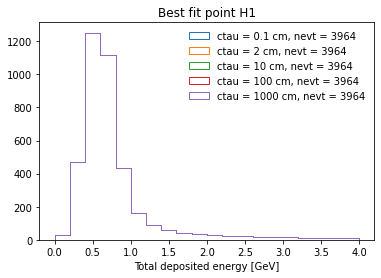

In [83]:
for ctau in ctaus:
    total_selection = selection & df[f'decay_in_tpc_{ctau}']
    out = plt.hist((df['plp', 't']+df['plm', 't']+df['pnu', 't']+df['pHad', 't']-df['recoil_mass', '']), 
                   bins=20, 
                   range=(0, 4), 
                   weights=df.loc[:, ('actual_weight', '')], 
                   label=f"ctau = {ctau} cm, nevt = {df.loc[:, ('actual_weight', '')].sum():.0f}", 
                   histtype='step')

plt.legend(frameon=False)
plt.xlabel('Total deposited energy [GeV]')
plt.title(f"Best fit point {model}")
plt.savefig(save_folder+"deposited_energy.png", dpi=250)